# Perform single-cell quality control

In this notebook, we perform single-cell quality control using coSMicQC. We use features from the AreaShape and Intensity modules to assess the quality of the segmented single-cells.

## Import modules

In [1]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

from cytodataframe import CytoDataFrame
from cosmicqc import find_outliers

## Set paths and variables

In [2]:
# Process redo plate or regular plates
redo_plate = True

if redo_plate:
    # Directory with data
    data_dir = pathlib.Path("./data/converted_profiles/Plate_2_redo/")
    # Directory to save cleaned data
    cleaned_dir = pathlib.Path("./data/cleaned_profiles/Plate_2_redo/")
    cleaned_dir.mkdir(exist_ok=True)
    # Set outline context directory
    outline_context_dir = next(
        pathlib.Path("../2.extract_features/cp_output/Plate_2_redo/").glob("CARD*")
    )
else:
    data_dir = pathlib.Path("./data/converted_profiles/")
    cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
    cleaned_dir.mkdir(exist_ok=True)
    # Set outline context directory
    outline_context_dir = next(
        pathlib.Path("../2.extract_features/cp_output/").glob("CARD*")
    )

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# Create an empty dictionary to store data frames for each plate
all_qc_data_frames = {}

## Load in plate to perform QC on

In [3]:
# Find the single converted parquet in the data directory and load it
files = list(data_dir.glob("*_converted.parquet"))

if len(files) == 0:
    raise FileNotFoundError(f"No *_converted.parquet files found in {data_dir}")
if len(files) > 1:
    print(
        f"More than one converted file found in {data_dir}, loading the first: {files[0].name}"
    )

file_path = files[0]
plate = file_path.stem.replace("_converted", "")

# Load in converted plate data
plate_df = pd.read_parquet(file_path)

# Add plate metadata column if absent
if "Image_Metadata_Plate" not in plate_df.columns:
    plate_df["Image_Metadata_Plate"] = plate

print(plate_df.shape)
plate_df.head()

(9933, 2476)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_02_256,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256
0,658.950181,133.526354,655.840801,145.906197,8,8,CARD-CelIns-CX7_251110170001,f11,B02,1,...,7.235763,6.820124,28.790843,25.668908,27.056171,28.936658,2.489488,2.524561,2.714171,2.487867
1,447.021930,78.739348,484.574235,96.405302,8,11,CARD-CelIns-CX7_251110170001,f17,B02,1,...,14.929112,14.343909,92.442490,98.489600,89.491760,82.556143,12.022663,12.248467,11.881171,11.092255
2,901.166307,143.648668,899.842264,187.085445,12,39,CARD-CelIns-CX7_251110170001,f00,B04,1,...,12.097805,12.197471,1.964058,1.945975,2.083970,2.101056,7.077019,6.946078,6.867486,6.768404
3,298.035906,54.772776,288.291241,114.819708,17,91,CARD-CelIns-CX7_251110170001,f07,B07,1,...,3.313076,3.460958,0.857484,0.847633,0.934912,0.961085,3.656769,3.795006,3.590538,3.668976
4,621.179219,88.804742,572.228177,149.077273,15,100,CARD-CelIns-CX7_251110170001,f18,B07,1,...,10.112048,10.461192,1.288340,1.416899,1.288473,1.196812,12.661273,10.548908,12.318059,13.956980


In [4]:
# set compartment for segmentation mask
compartment = "Nuclei"

# channels to include for cytodataframe visualization
channels = ["Hoechst", "Actin"]

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    *[f"Metadata_{compartment}_Location_Center_{axis}" for axis in ("X", "Y")],
    *[f"Image_FileName_{ch}" for ch in channels],
    *[f"Image_PathName_{ch}" for ch in channels],
    *[
        f"{compartment}_AreaShape_BoundingBox{bound}_{axis}"
        for bound in ("Maximum", "Minimum")
        for axis in ("X", "Y")
    ],
]

In [5]:
# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {}
for record in plate_df[
    [
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
    ]
].to_dict(orient="records"):
    site_raw = str(record["Image_Metadata_Site"])
    # extract digits from the site string (e.g., 'f09' -> '09')
    site_digits = re.sub(r"\D", "", site_raw)
    if site_digits == "":
        site_fmt = site_raw
    else:
        site_fmt = f"{int(site_digits):02d}"

    key = rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff"
    value = rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}f{site_fmt}d\d+_illumcorrect\.tiff"
    outline_to_orig_mapping[key] = value
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('NucleiOutlines_CARD-CelIns-CX7_251110170001_B02_f11.tiff',
 'CARD-CelIns-CX7_251110170001_B02f11d\\d+_illumcorrect\\.tiff')

## Oversegmented nuclei with very high intensity (clusters)

Number of outliers: 221 (2.22%)
Outliers Range:
Nuclei_Intensity_MassDisplacement_Hoechst Min: 0.8024109880701787
Nuclei_Intensity_MassDisplacement_Hoechst Max: 8.292191625112158
Nuclei_AreaShape_Solidity Min: 0.599591419816139
Nuclei_AreaShape_Solidity Max: 0.9570405727923628
(221, 3)


,1040,6686,1466,1270,680
Nuclei_Intensity_MassDisplacement_Hoechst,3.328794,1.032455,1.553898,1.352274,1.194492
Nuclei_AreaShape_Solidity,0.950492,0.800878,0.898625,0.940511,0.950692
Image_FileName_Hoechst,,,,,

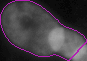
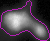
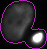
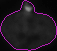
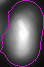

In [6]:
# find large nuclei clusters
feature_thresholds = {
    "Nuclei_Intensity_MassDisplacement_Hoechst": 1.0,
    "Nuclei_AreaShape_Solidity": -0.8,
}

oversegmented_nuclei_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
oversegmented_nuclei_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(oversegmented_nuclei_outliers),
    data_outline_context_dir=outline_context_dir,
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Nuclei_Intensity_MassDisplacement_Hoechst",
        "Nuclei_AreaShape_Solidity",
        "Image_FileName_Hoechst",
    ]
]


print(oversegmented_nuclei_outliers_cdf.shape)
# oversegmented_nuclei_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
oversegmented_nuclei_outliers_cdf.sample(n=5).T

Number of outliers: 206 (2.07%)
Outliers Range:
Nuclei_AreaShape_Solidity Min: 0.599591419816139
Nuclei_AreaShape_Solidity Max: 0.9273084479371316
(206, 2)


,8541,2292,7003,9842,5880
Nuclei_AreaShape_Solidity,0.599591,0.927134,0.914751,0.893878,0.906726
Image_FileName_Hoechst,,,,,

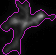
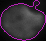
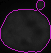
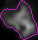
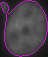

In [7]:
# find non-round nuclei (poorly segmented)
feature_thresholds = {
    "Nuclei_AreaShape_Solidity": -2.2,
}

poorly_segmented_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
poorly_segmented_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(poorly_segmented_outliers),
    data_outline_context_dir=outline_context_dir,
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Nuclei_AreaShape_Solidity",
        "Image_FileName_Hoechst",
    ]
]


print(poorly_segmented_outliers_cdf.shape)
# large_nuclei_high_int_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
poorly_segmented_outliers_cdf.sample(n=5).T

### Scatterplot of mass displacement to solidity

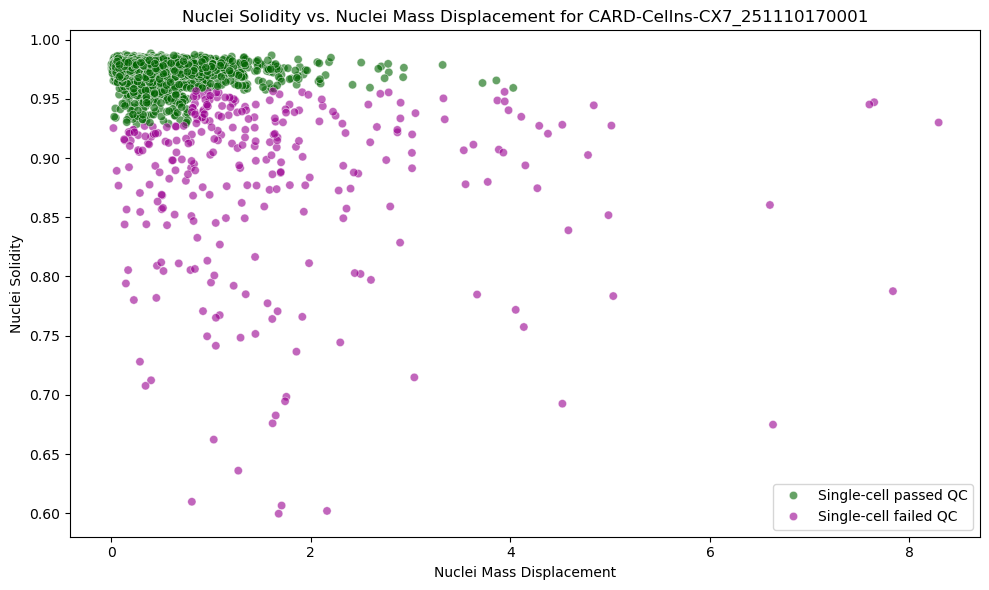

In [8]:
# Set the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from both nuclei clusters and poorly segmented nuclei
combined_idx = pd.Index(oversegmented_nuclei_outliers.index).union(
    pd.Index(poorly_segmented_outliers.index)
)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_Intensity_MassDisplacement_Hoechst",
    y="Nuclei_AreaShape_Solidity",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },  # Specify colors
    alpha=0.6,
)

plt.title(f"Nuclei Solidity vs. Nuclei Mass Displacement for {plate}")
plt.xlabel("Nuclei Mass Displacement")
plt.ylabel("Nuclei Solidity")
plt.tight_layout()

# Show the legend
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0), prop={"size": 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_nuclei_outliers.png"), dpi=500)

plt.show()

## Mis-segmented cells due to high confluence (segmentation for cells around the nuclei)

In [9]:
# set compartment for segmentation mask
compartment = "Cells"

# channels to include for cytodataframe visualization
channels = ["Hoechst", "Actin"]

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    *[f"Metadata_{compartment}_Location_Center_{axis}" for axis in ("X", "Y")],
    *[f"Image_FileName_{ch}" for ch in channels],
    *[f"Image_PathName_{ch}" for ch in channels],
    *[
        f"{compartment}_AreaShape_BoundingBox{bound}_{axis}"
        for bound in ("Maximum", "Minimum")
        for axis in ("X", "Y")
    ],
]

In [10]:
# create an outline and orig mapping dictionary to map original images to outlines
# note: we turn off formatting here to avoid the key-value pairing definition
# from being reformatted by black, which is normally preferred.
# fmt: off
outline_to_orig_mapping = {}
for record in plate_df[
    [
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
    ]
].to_dict(orient="records"):
    site_raw = str(record["Image_Metadata_Site"])
    # extract digits from the site string (e.g., 'f09' -> '09')
    site_digits = re.sub(r"\D", "", site_raw)
    if site_digits == "":
        site_fmt = site_raw
    else:
        site_fmt = f"{int(site_digits):02d}"

    key = rf"{compartment}Outlines_{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}_{record['Image_Metadata_Site']}.tiff"
    value = rf"{record['Image_Metadata_Plate']}_{record['Image_Metadata_Well']}f{site_fmt}d\d+_illumcorrect\.tiff"
    outline_to_orig_mapping[key] = value
# fmt: on

next(iter(outline_to_orig_mapping.items()))

('CellsOutlines_CARD-CelIns-CX7_251110170001_B02_f11.tiff',
 'CARD-CelIns-CX7_251110170001_B02f11d\\d+_illumcorrect\\.tiff')

Number of outliers: 496 (4.99%)
Outliers Range:
Cells_AreaShape_Area Min: 709.0
Cells_AreaShape_Area Max: 7727.0
(496, 2)


,7987,1251,635,9928,4261
Cells_AreaShape_Area,3479.0,1819.0,1583.0,5064.0,1372.0
Image_FileName_Actin,,,,,

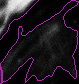
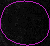
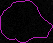
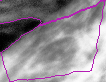
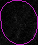

In [11]:
# find under-segmented cells (small cells)
feature_thresholds = {
    "Cells_AreaShape_Area": -1.5,
}

small_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
small_cells_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(small_cells_outliers),
    data_outline_context_dir=outline_context_dir,
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "outline_color": (180, 30, 180),  # magenta
        "brightness": 1,
    },
)[
    [
        "Cells_AreaShape_Area",
        "Image_FileName_Actin",
    ]
]


print(small_cells_outliers_cdf.shape)
# large_nuclei_high_int_outliers_cdf.sort_values(
#     by="Nuclei_Intensity_MassDisplacement_Hoechst", ascending=True
# ).head(5).T
small_cells_outliers_cdf.sample(n=5).T

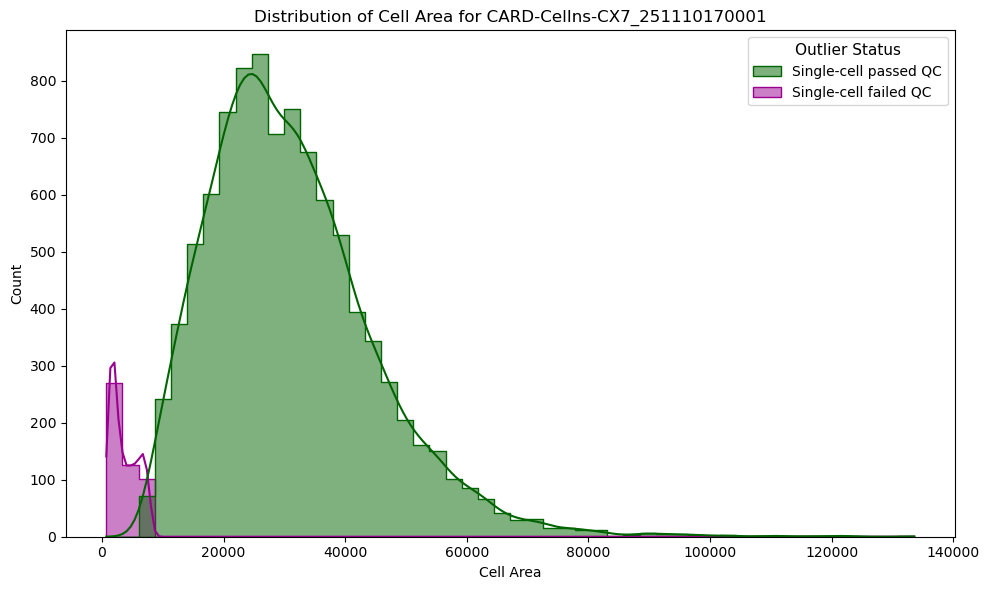

In [12]:
# Set default value
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from under-segmented cells
combined_idx = pd.Index(small_cells_outliers.index)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create plot
plt.figure(figsize=(10, 6))
ax = sns.histplot(
    data=plate_df,
    x="Cells_AreaShape_Area",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },
    element="step",
    bins=50,
    alpha=0.5,
    kde=True,  # adds KDE overlay
)

plt.title(f"Distribution of Cell Area for {plate}")
plt.xlabel("Cell Area")
plt.ylabel("Count")

# Customize the Seaborn-generated legend instead of creating a new one
ax.legend_.set_title("Outlier Status")
ax.legend_.set_bbox_to_anchor((1.0, 1.0))
for text in ax.legend_.get_texts():
    text.set_fontsize(10)
ax.legend_.get_title().set_fontsize(11)

plt.tight_layout()
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_cells_outliers.png"), dpi=500)
plt.show()

## Detect blurry cells

We decided to use texture in the nucleus (nucleus compartment) and actin (cells compartment) to identify out-of-focus cells as it is expected that the pixel intensities will be homogenous across the cell (lack of texture).

Number of outliers: 398 (4.01%)
Outliers Range:
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256 Min: -0.3975126743846096
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256 Max: -0.22516756003174143
Cells_Texture_InfoMeas1_Actin_3_02_256 Min: -0.6368227134927564
Cells_Texture_InfoMeas1_Actin_3_02_256 Max: -0.3176499935963499
(398, 5)


,9207,433,7363,9805,4269
Image_Metadata_Well,C07,G02,B06,C06,G05
Image_Metadata_Site,f00,f07,f23,f08,f10
Nuclei_Texture_InfoMeas1_Hoechst_3_02_256,-0.249434,-0.227549,-0.2769,-0.282491,-0.228104
Cells_Texture_InfoMeas1_Actin_3_02_256,-0.340909,-0.398036,-0.325565,-0.320555,-0.382826
Image_FileName_Actin,,,,,

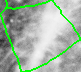
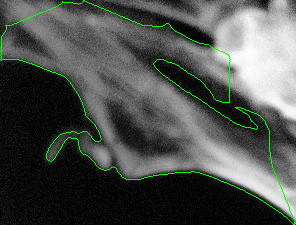
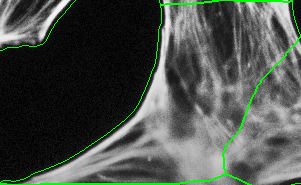
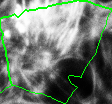
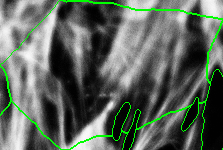

In [13]:
# find blurry cells
feature_thresholds = {
    "Nuclei_Texture_InfoMeas1_Hoechst_3_02_256": -1.5,
    "Cells_Texture_InfoMeas1_Actin_3_02_256": -1.0,
}

blurry_cells_outliers = find_outliers(
    df=plate_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

# MUST SET DATA AS DATAFRAME FOR OUTLINE DIR TO WORK
blurry_cells_outliers_cdf = CytoDataFrame(
    data=pd.DataFrame(blurry_cells_outliers),
    data_outline_context_dir=outline_context_dir,
    segmentation_file_regex=outline_to_orig_mapping,
    display_options={
        "center_dot": False,
        "brightness": 5,
    },
)[
    [
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Nuclei_Texture_InfoMeas1_Hoechst_3_02_256",
        "Cells_Texture_InfoMeas1_Actin_3_02_256",
        "Image_FileName_Actin",
    ]
]


print(blurry_cells_outliers_cdf.shape)
# blurry_cells_outliers_cdf.sort_values(
#     by="Nuclei_Texture_InfoMeas1_Hoechst_3_02_256", ascending=False
# ).head(10)
blurry_cells_outliers_cdf.sample(n=5).T

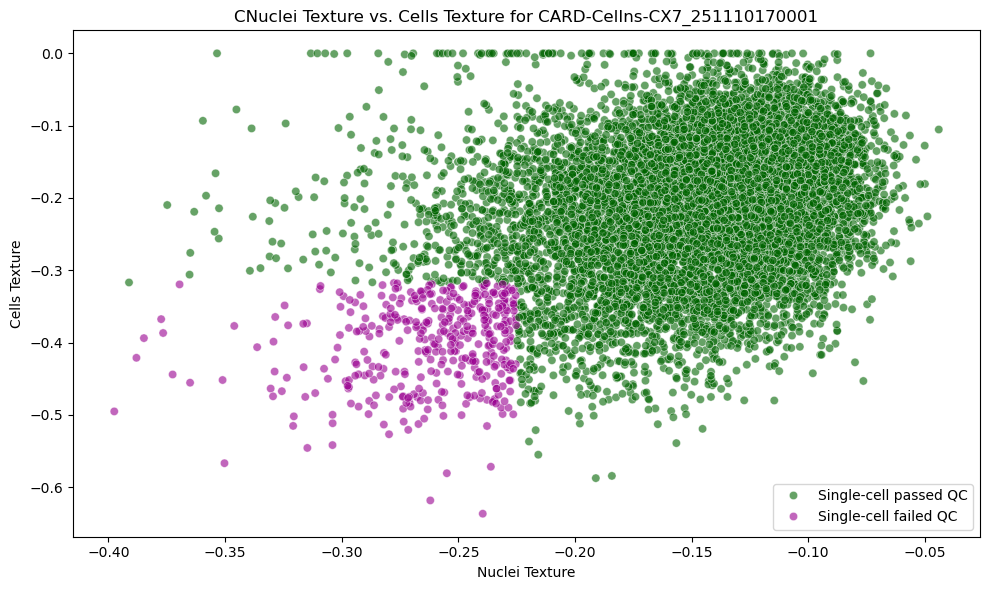

In [14]:
# Set the default value to 'inlier'
plate_df["Outlier_Status"] = "Single-cell passed QC"

# Mark outliers from under-segmented cells
combined_idx = pd.Index(blurry_cells_outliers.index)
plate_df.loc[plate_df.index.isin(combined_idx), "Outlier_Status"] = (
    "Single-cell failed QC"
)

# Create scatter plot
plt.figure(figsize=(10, 6))
plot = sns.scatterplot(
    data=plate_df,
    x="Nuclei_Texture_InfoMeas1_Hoechst_3_02_256",
    y="Cells_Texture_InfoMeas1_Actin_3_02_256",
    hue="Outlier_Status",
    palette={
        "Single-cell passed QC": "#006400",
        "Single-cell failed QC": "#990090",
    },  # Specify colors
    alpha=0.6,
)

plt.title(f"CNuclei Texture vs. Cells Texture for {plate}")
plt.xlabel("Nuclei Texture")
plt.ylabel("Cells Texture")
plt.tight_layout()

# Show the legend
plt.legend(loc="lower right", bbox_to_anchor=(1.0, 0), prop={"size": 10})

# Save figure
plt.savefig(pathlib.Path(f"{qc_fig_dir}/{plate}_blurry_outliers.png"), dpi=500)

plt.show()

## Remove all outliers and save cleaned data frame

In [15]:
# Collect indices from all known outlier dataframes in the notebook
outlier_names = [
    "large_nuclei_high_int_outliers",
    "oversegmented_nuclei_outliers",
    "poorly_segmented_outliers",
    "small_cells_outliers",
    "blurry_cells_outliers",
]

outlier_frames = []
for name in outlier_names:
    try:
        obj = eval(name)
    except NameError:
        continue

    # If already a DataFrame or CytoDataFrame-like, take it; otherwise try to coerce
    if isinstance(obj, pd.DataFrame):
        outlier_frames.append(obj)
    else:
        try:
            outlier_frames.append(pd.DataFrame(obj))
        except Exception:
            # skip objects that cannot be converted
            continue

if outlier_frames:
    outlier_indices = pd.Index(pd.concat(outlier_frames).index.unique())
else:
    outlier_indices = pd.Index([])

print(
    f"Found {len(outlier_indices)} unique outlier indices from: "
    + ", ".join([n for n in outlier_names if n in globals()])
)

# Remove rows with outlier indices from plate_4_df
plate_df_cleaned = plate_df.drop(outlier_indices)

# Save cleaned data for this plate
plate_name = plate_df["Image_Metadata_Plate"].iloc[0]
plate_df_cleaned.to_parquet(f"{cleaned_dir}/{plate_name}_cleaned.parquet")

# Verify the result
print(plate_df_cleaned.shape)
plate_df_cleaned.head()

Found 1081 unique outlier indices from: oversegmented_nuclei_outliers, poorly_segmented_outliers, small_cells_outliers, blurry_cells_outliers
(8852, 2477)


,Metadata_Nuclei_Location_Center_X,Metadata_Nuclei_Location_Center_Y,Metadata_Cells_Location_Center_X,Metadata_Cells_Location_Center_Y,Metadata_Image_Count_Cells,Metadata_ImageNumber,Image_Metadata_Plate,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,...,Nuclei_Texture_Variance_Hoechst_3_03_256,Nuclei_Texture_Variance_Mitochondria_3_00_256,Nuclei_Texture_Variance_Mitochondria_3_01_256,Nuclei_Texture_Variance_Mitochondria_3_02_256,Nuclei_Texture_Variance_Mitochondria_3_03_256,Nuclei_Texture_Variance_PM_3_00_256,Nuclei_Texture_Variance_PM_3_01_256,Nuclei_Texture_Variance_PM_3_02_256,Nuclei_Texture_Variance_PM_3_03_256,Outlier_Status
0,658.950181,133.526354,655.840801,145.906197,8,8,CARD-CelIns-CX7_251110170001,f11,B02,1,...,6.820124,28.790843,25.668908,27.056171,28.936658,2.489488,2.524561,2.714171,2.487867,Single-cell passed QC
2,901.166307,143.648668,899.842264,187.085445,12,39,CARD-CelIns-CX7_251110170001,f00,B04,1,...,12.197471,1.964058,1.945975,2.083970,2.101056,7.077019,6.946078,6.867486,6.768404,Single-cell passed QC
9,834.321605,182.925309,841.082528,153.563525,13,160,CARD-CelIns-CX7_251110170001,f04,B11,1,...,6.177270,9.210688,8.923945,9.261031,9.356402,5.745164,5.728802,5.818008,5.677750,Single-cell passed QC
11,338.623474,190.446948,298.059018,212.527187,7,216,CARD-CelIns-CX7_251110170001,f12,C04,1,...,32.503938,14.594587,12.885511,16.042805,16.667187,5.234611,5.146296,5.659207,5.360228,Single-cell passed QC
15,287.499276,191.617221,276.583431,234.584192,4,270,CARD-CelIns-CX7_251110170001,f00,C08,1,...,8.343528,0.360459,0.312033,0.356023,0.347599,3.255724,2.921431,2.974471,2.979452,Single-cell passed QC


In [16]:
# Compute overall and per-well QC failure rates using outlier_indices
if "plate_df" not in globals():
    raise NameError(
        "plate_df not found in the notebook namespace. Run the cell that loads the plate first."
    )
if "outlier_indices" not in globals():
    raise NameError(
        "outlier_indices not found. Run the cell that collects outlier indices (cell 22)."
    )

df_all = plate_df
total_cells = len(df_all)

# Ensure outlier_indices is an Index and restrict to indices present in plate_df
out_idx = pd.Index(outlier_indices)
out_idx_in_df = df_all.index.intersection(out_idx)

n_failed = int(len(out_idx_in_df))
pct_failed = n_failed / total_cells * 100 if total_cells else 0.0

print(f"Total cells: {total_cells}")
print(f"Outlier indices provided: {len(out_idx)}")
print(f"Outlier indices present in plate_df: {n_failed} ({pct_failed:.2f}%)")

# Per-well failure percentages using outlier indices
well_counts = df_all.groupby("Image_Metadata_Well").size().rename("total")
well_failed = (
    df_all.loc[df_all.index.isin(out_idx_in_df)]
    .groupby("Image_Metadata_Well")
    .size()
    .rename("failed")
)

well_stats = (
    pd.concat([well_counts, well_failed], axis=1)
    .fillna(0)
    .astype({"total": int, "failed": int})
)
well_stats["failed_pct"] = well_stats["failed"] / well_stats["total"] * 100

# Sort and show top wells
well_stats = well_stats.sort_values("failed_pct", ascending=False)
top_n = globals().get("top_n", 10)
print(f"\nTop {top_n} wells by % failed:")
print(well_stats.head(top_n).to_string())

# Save summary for later use
plate_qc_summary = {
    "total_cells": total_cells,
    "failed_cells": n_failed,
    "failed_pct": pct_failed,
    "outlier_indices_total": len(out_idx),
    "outlier_indices_used": len(out_idx_in_df),
    "well_stats": well_stats,
}

Total cells: 9933
Outlier indices provided: 1081
Outlier indices present in plate_df: 1081 (10.88%)

Top 10 wells by % failed:
                     total  failed  failed_pct
Image_Metadata_Well                           
G05                    249      52   20.883534
G02                    132      27   20.454545
G04                    385      69   17.922078
G06                    181      30   16.574586
B02                    164      27   16.463415
D03                    417      67   16.067146
E05                    162      24   14.814815
E11                    345      51   14.782609
F09                    147      21   14.285714
C10                    170      23   13.529412
